# Cleaning US Census Data

You just got hired as a Data Analyst at the Census Bureau, which collects census data and creates interesting visualizations and insights from it.

The person who had your job before you left you all the data they had for the most recent census. It is in multiple `csv` files. They didn't use pandas, they would just look through these `csv` files manually whenever they wanted to find something. Sometimes they would copy and paste certain numbers into Excel to make charts.

The thought of it makes you shiver. This is not scalable or repeatable.

Your boss wants you to make some scatterplots and histograms by the end of the day. Can you get this data into `pandas` and into reasonable shape so that you can make these histograms?

## Inspect the Data!

1. The first visualization your boss wants you to make is a scatterplot that shows average income in a state vs proportion of women in that state.

   Open some of the census `csv` files that came with the kit you downloaded. How are they named? What kind of information do they hold? Will they help us make this graph?

I noted that some columns representing the ethnic breakdown of the population are missing values. There were also instances where the genderPop column had incomplete data for either the M or F population.

2. It will be easier to inspect this data once we have it in a DataFrame. You can't even call `.head()` on these `csv`s! How are you supposed to read them?

   Using `glob`, loop through the census files available and load them into DataFrames. Then, concatenate all of those DataFrames together into one DataFrame, called something like `us_census`.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

files = glob.glob("states*.csv")
df_list = []
for file in files:
    data = pd.read_csv(file, index_col=0)
    df_list.append(data)
    
us_census = pd.concat(df_list).reset_index(drop=True)
#us_census = us_census.drop(columns = ['Unnamed']) this doesn't work. using the index_col=0 ignored the index col in the .csv files.
print(us_census.head(5))
print(us_census.dtypes)

        State  TotalPop Hispanic   White   Black  Native   Asian Pacific  \
0     Alabama   4830620    3.75%  61.88%  31.25%   0.45%   1.05%   0.03%   
1      Alaska    733375    5.91%  60.91%   2.85%  16.39%   5.45%   1.06%   
2     Arizona   6641928   29.57%  57.12%   3.85%   4.36%   2.88%   0.17%   
3    Arkansas   2958208    6.22%  71.14%  18.97%   0.52%   1.14%   0.15%   
4  California  38421464   37.29%  40.22%   5.68%   0.41%  13.05%   0.35%   

        Income            GenderPop  
0  $43,296.36     2341093M_2489527F  
1  $70,354.74       384160M_349215F  
2  $54,207.82     3299088M_3342840F  
3  $41,935.63     1451913M_1506295F  
4  $67,264.78   19087135M_19334329F  
State        object
TotalPop      int64
Hispanic     object
White        object
Black        object
Native       object
Asian        object
Pacific      object
Income       object
GenderPop    object
dtype: object


3. Look at the `.columns` and the `.dtypes` of the `us_census` DataFrame. Are those datatypes going to hinder you as you try to make histograms?

* State         object
* TotalPop       int64
* Hispanic      object --> Each percentage of race needs to be converted to a float to support reporting of statistics
* White         object
* Black         object
* Native        object
* Asian         object
* Pacific       object
* Income        object --> convert to a float to support reporting
* GenderPop     object --> combined string that needs to be split into Male Pop and Female Pop
* dtype: object

4. Look at the `head()` of the DataFrame so that you can understand why some of these `dtypes` are objects instead of integers or floats.

   Start to make a plan for how to convert these columns into the right types for manipulation.

   Unnamed: 0       State  TotalPop Hispanic   White   Black  Native   Asian  \
0           0     Alabama   4830620    3.75%  61.88%  31.25%   0.45%   1.05%   
1           1      Alaska    733375    5.91%  60.91%   2.85%  16.39%   5.45%   
2           2     Arizona   6641928   29.57%  57.12%   3.85%   4.36%   2.88%   
3           3    Arkansas   2958208    6.22%  71.14%  18.97%   0.52%   1.14%   
4           4  California  38421464   37.29%  40.22%   5.68%   0.41%  13.05%   

  Pacific       Income            GenderPop  
0   0.03%  $43,296.36     2341093M_2489527F  
1   1.06%  $70,354.74       384160M_349215F  
2   0.17%  $54,207.82     3299088M_3342840F  
3   0.15%  $41,935.63     1451913M_1506295F  
4   0.35%  $67,264.78   19087135M_19334329F

## Regex to the Rescue

5. Use regex to turn the `Income` column into a format that is ready for conversion into a numerical type.

In [60]:
us_census.Income = us_census['Income'].replace('[\$\,\.]','', regex = True)
us_census.Income = pd.to_numeric(us_census.Income)
print(us_census.Income.head(5))

0    4329636
1    7035474
2    5420782
3    4193563
4    6726478
Name: Income, dtype: int64


6. Look at the `GenderPop` column. We are going to want to separate this into two columns, the `Men` column, and the `Women` column.

   Split the column into those two new columns using `str.split` and separating out those results.

In [61]:
split_df = us_census['GenderPop'].str.split('_', expand =True)
us_census['Men'] = split_df[0].replace('[M]','', regex=True)
us_census['Women'] = split_df[1].replace('[F]','', regex=True)
print(us_census.head(5))

        State  TotalPop Hispanic   White   Black  Native   Asian Pacific  \
0     Alabama   4830620    3.75%  61.88%  31.25%   0.45%   1.05%   0.03%   
1      Alaska    733375    5.91%  60.91%   2.85%  16.39%   5.45%   1.06%   
2     Arizona   6641928   29.57%  57.12%   3.85%   4.36%   2.88%   0.17%   
3    Arkansas   2958208    6.22%  71.14%  18.97%   0.52%   1.14%   0.15%   
4  California  38421464   37.29%  40.22%   5.68%   0.41%  13.05%   0.35%   

    Income            GenderPop       Men     Women  
0  4329636    2341093M_2489527F   2341093   2489527  
1  7035474      384160M_349215F    384160    349215  
2  5420782    3299088M_3342840F   3299088   3342840  
3  4193563    1451913M_1506295F   1451913   1506295  
4  6726478  19087135M_19334329F  19087135  19334329  


7. Convert both of the columns into numerical datatypes.

   There is still an `M` or an `F` character in each entry! We should remove those before we convert.

In [62]:
us_census.Men = pd.to_numeric(us_census.Men)
us_census.Women = pd.to_numeric(us_census.Women)
print(us_census.dtypes)

State         object
TotalPop       int64
Hispanic      object
White         object
Black         object
Native        object
Asian         object
Pacific       object
Income         int64
GenderPop     object
Men            int64
Women        float64
dtype: object


8. Now you should have the columns you need to make the graph and make sure your boss does not slam a ruler angrily on your desk because you've wasted your whole day cleaning your data with no results to show!

   Use matplotlib to make a scatterplot!
   
   ```py
   plt.scatter(the_women_column, the_income_column)
   ```
   
   Remember to call `plt.show()` to see the graph!

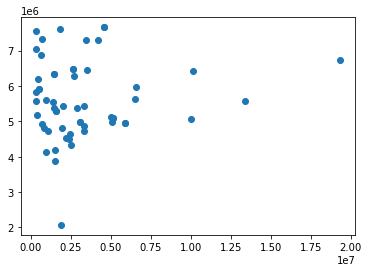

In [63]:
plt.scatter(us_census.Women, us_census.Income)
plt.show()

9. You want to double check your work. You know from experience that these monstrous csv files probably have `nan` values in them! Print out your column with the number of women per state to see.

   We can fill in those `nan`s by using pandas' `.fillna()` function.
   
   You have the `TotalPop` per state, and you have the `Men` per state. As an estimate for the `nan` values in the `Women` column, you could use the `TotalPop` of that state minus the `Men` for that state.
   
   Print out the `Women` column after filling the `nan` values to see if it worked!

In [64]:
us_census = us_census.fillna(value = {'Women':(us_census.TotalPop - us_census.Men)})
print(us_census)

                   State  TotalPop Hispanic   White   Black  Native   Asian  \
0                Alabama   4830620    3.75%  61.88%  31.25%   0.45%   1.05%   
1                 Alaska    733375    5.91%  60.91%   2.85%  16.39%   5.45%   
2                Arizona   6641928   29.57%  57.12%   3.85%   4.36%   2.88%   
3               Arkansas   2958208    6.22%  71.14%  18.97%   0.52%   1.14%   
4             California  38421464   37.29%  40.22%   5.68%   0.41%  13.05%   
5               Colorado   5278906   20.78%  69.90%   3.55%   0.57%   2.66%   
6               Colorado   5278906   20.78%  69.90%   3.55%   0.57%   2.66%   
7            Connecticut   3593222   15.60%  67.68%  10.35%   0.13%   4.02%   
8               Delaware    926454    8.82%  64.63%  20.74%   0.26%   3.27%   
9   District of Columbia    647484    9.17%  33.10%  51.78%   0.20%   3.38%   
10               Florida  19645772   21.34%  59.08%  15.17%   0.21%   2.28%   
11               Georgia  10006693    8.42%  54.29% 

10. We forgot to check for duplicates! Use `.duplicated()` on your `census` DataFrame to see if we have duplicate rows in there.

In [65]:
duplicates = us_census.duplicated()
print(duplicates.value_counts())

False    51
True      9
dtype: int64


11. Drop those duplicates using the `.drop_duplicates()` function.

In [66]:
us_census = us_census.drop_duplicates()

12. Make the scatterplot again. Now, it should be perfect! Your job is secure, for now.

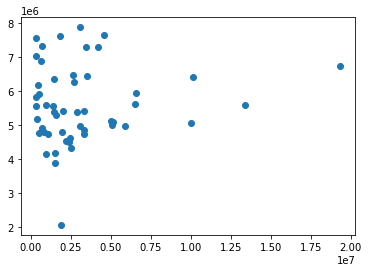

In [67]:
plt.scatter(us_census.Women, us_census.Income)
plt.show()

## Histogram of Races

13. Now your boss wants you to make a bunch of histograms out of the race data that you have. Look at the `.columns` again to see what the race categories are.

In [68]:
print(us_census.columns)

Index(['State', 'TotalPop', 'Hispanic', 'White', 'Black', 'Native', 'Asian',
       'Pacific', 'Income', 'GenderPop', 'Men', 'Women'],
      dtype='object')


14. Try to make a histogram for each one!

    You will have to get the columns into the numerical format, and those percentage signs will have to go.
    
    Don't forget to fill the `nan` values with something that makes sense! You probably dropped the duplicate rows when making your last graph, but it couldn't hurt to check for duplicates again.

In [69]:
us_census.Hispanic = us_census['Hispanic'].replace('[\%]','', regex = True)
us_census.Hispanic = pd.to_numeric(us_census.Hispanic)
us_census.White = us_census['White'].replace('[\%]','', regex = True)
us_census.White = pd.to_numeric(us_census.White)
us_census.Black = us_census['Black'].replace('[\%]','', regex = True)
us_census.Black = pd.to_numeric(us_census.Black)
us_census.Native = us_census['Native'].replace('[\%]','', regex = True)
us_census.Native = pd.to_numeric(us_census.Native)
us_census.Asian = us_census['Asian'].replace('[\%]','', regex = True)
us_census.Asian = pd.to_numeric(us_census.Asian)
us_census.Pacific = us_census['Pacific'].replace('[\%]','', regex = True)
us_census.Pacific = pd.to_numeric(us_census.Pacific)
us_census = us_census.fillna(value = {'Hispanic':(100 - (us_census.Asian+us_census.White+us_census.Black+us_census.Native+us_census.Pacific))})
us_census = us_census.fillna(value = {'Asian':(100 - (us_census.Hispanic+us_census.White+us_census.Black+us_census.Native+us_census.Pacific))})
us_census = us_census.fillna(value = {'White':(100 - (us_census.Asian+us_census.Hispanic+us_census.Black+us_census.Native+us_census.Pacific))})
us_census = us_census.fillna(value = {'Black':(100 - (us_census.Asian+us_census.White+us_census.Hispanic+us_census.Native+us_census.Pacific))})
us_census = us_census.fillna(value = {'Pacific':(100 - (us_census.Asian+us_census.White+us_census.Black+us_census.Native+us_census.Hispanic))})
us_census = us_census.fillna(value = {'Native':(100 - (us_census.Asian+us_census.White+us_census.Black+us_census.Hispanic+us_census.Pacific))})
print(us_census)
duplicates = us_census.duplicated()
print(duplicates.value_counts())

                   State  TotalPop  Hispanic  White  Black  Native  Asian  \
0                Alabama   4830620      3.75  61.88  31.25    0.45   1.05   
1                 Alaska    733375      5.91  60.91   2.85   16.39   5.45   
2                Arizona   6641928     29.57  57.12   3.85    4.36   2.88   
3               Arkansas   2958208      6.22  71.14  18.97    0.52   1.14   
4             California  38421464     37.29  40.22   5.68    0.41  13.05   
5               Colorado   5278906     20.78  69.90   3.55    0.57   2.66   
7            Connecticut   3593222     15.60  67.68  10.35    0.13   4.02   
8               Delaware    926454      8.82  64.63  20.74    0.26   3.27   
9   District of Columbia    647484      9.17  33.10  51.78    0.20   3.38   
10               Florida  19645772     21.34  59.08  15.17    0.21   2.28   
11               Georgia  10006693      8.42  54.29  32.09    0.19   3.10   
13                Hawaii   1406299      9.19  25.03   2.05    0.14  36.59   

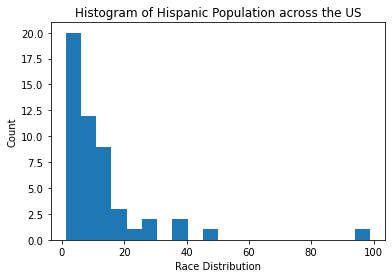

In [79]:
# creating a histogram of each race in the data
n, bins, patches = plt.hist(us_census.Hispanic, 20)
plt.xlabel('Percentage in a given State, Territory')
plt.ylabel('Count')
plt.title('Histogram of Hispanic Population across the US')
plt.show()


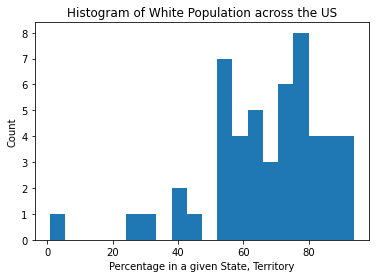

In [82]:
n, bins, patches = plt.hist(us_census.White, 20)
plt.xlabel('Percentage in a given State, Territory')
plt.ylabel('Count')
plt.title('Histogram of White Population across the US')
plt.show()

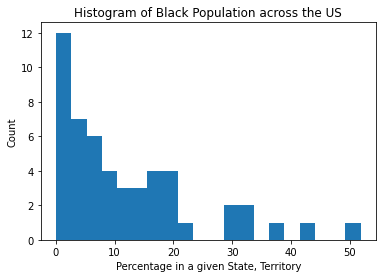

In [81]:
# creating a histogram of each race in the data
n, bins, patches = plt.hist(us_census.Black, 20)
plt.xlabel('Percentage in a given State, Territory')
plt.ylabel('Count')
plt.title('Histogram of Black Population across the US')
plt.show()

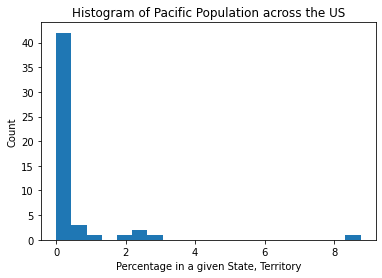

In [83]:
# creating a histogram of each race in the data
n, bins, patches = plt.hist(us_census.Pacific, 20)
plt.xlabel('Percentage in a given State, Territory')
plt.ylabel('Count')
plt.title('Histogram of Pacific Population across the US')
plt.show()

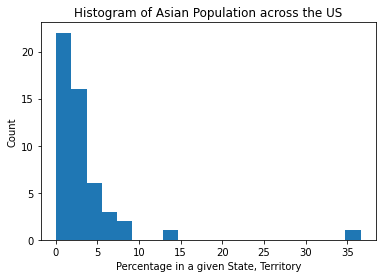

In [84]:
# creating a histogram of each race in the data
n, bins, patches = plt.hist(us_census.Asian, 20)
plt.xlabel('Percentage in a given State, Territory')
plt.ylabel('Count')
plt.title('Histogram of Asian Population across the US')
plt.show()

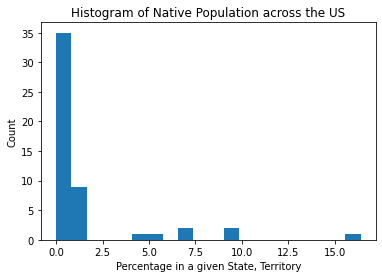

In [85]:
# creating a histogram of each race in the data
n, bins, patches = plt.hist(us_census.Native, 20)
plt.xlabel('Percentage in a given State, Territory')
plt.ylabel('Count')
plt.title('Histogram of Native Population across the US')
plt.show()

## Get Creative

15. Phew. You've definitely impressed your boss on your first day of work.

    But is there a way you really convey the power of pandas and Python over the drudgery of `csv` and Excel?
    
    Try to make some more interesting graphs to show your boss, and the world! You may need to clean the data even more to do it, or the cleaning you have already done may give you the ease of manipulation you've been searching for.